In [27]:
import pandas as pd
import scanpy as sc
import numpy as np
from collections import defaultdict

from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import colorcet as cc

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'
path_save='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/ct_composition/subtypes/'

Load data

In [3]:
# Get alpha cells
obs_names=sc.read(
    path_data+'data_integrated_analysed.h5ad',backed='r'
    ).obs.query('cell_type_integrated_v1=="alpha"').index
obs_names.shape

(40935,)

In [4]:
# Raw for claculating quiality metrics
adata_raw=sc.read(path_data+'data_integrated_analysed.h5ad')[obs_names,:].raw.to_adata()

In [8]:
# Load rawnorm. Correctly norm expression is in layers X_sf_integrated
adata_rn=sc.read(path_data+'data_rawnorm_integrated_annotated.h5ad')[obs_names,:].copy()
adata_rn.X=adata_rn.layers['X_sf_integrated']

In [10]:
# Redo embedding
sc.pp.neighbors(adata_rn, use_rep='X_integrated'  )
sc.tl.umap(adata_rn)

#### get QC metrics

In [11]:
# Add empty drops metric
files=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/raw_file_list.tsv')
files.index=[study+'_'+sample for study,sample in zip(files['study'],files['sample'])]
for study_sample in adata_rn.obs.study_sample.unique():
    file=files.at[study_sample,'dir'].replace('storage','lustre')+'raw_'+files.at[study_sample,'ending']
    # Index used in raw and merged data
    index_raw=adata_rn.obs_names[adata_rn.obs.study_sample==study_sample]
    index_parsed=[
        idx.replace('-'+files.at[study_sample,'sample']+'-'+files.at[study_sample,'study'],'')
        for idx in index_raw]
    # Load ambient info
    adata_rn.obs.loc[index_raw,'emptyDrops_LogProb'
                     ]=sc.read(file,backed='r').obs.loc[index_parsed,'emptyDrops_LogProb'].values

In [28]:
adata_rn.obs['emptyDrops_LogProb_scaled']=adata_rn.obs.groupby('study_sample')['emptyDrops_LogProb'].apply(
        lambda x: pd.DataFrame(minmax_scale(x),index=x.index,columns=['emptyDrops_LogProb_scaled'])
).unstack()['emptyDrops_LogProb_scaled']

In [12]:
# Calculate QC metrics
adata_rn.obs['n_counts']=np.array(adata_raw.X.sum(axis=1)).ravel()
adata_rn.obs['log10_n_counts']=np.log10(adata_rn.obs['n_counts']).ravel()
adata_rn.obs['n_genes']=np.array((adata_raw.X > 0).sum(axis = 1)).ravel()
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') 
                               for gene in adata_rn.var.gene_symbol])
adata_rn.obs['mt_frac'] = np.sum(
    adata_raw[:, mt_gene_mask].X, axis=1).A1/adata_rn.obs['n_counts']

#### Analyse clusters - QC and markers

Trying to set attribute `.uns` of view, copying.


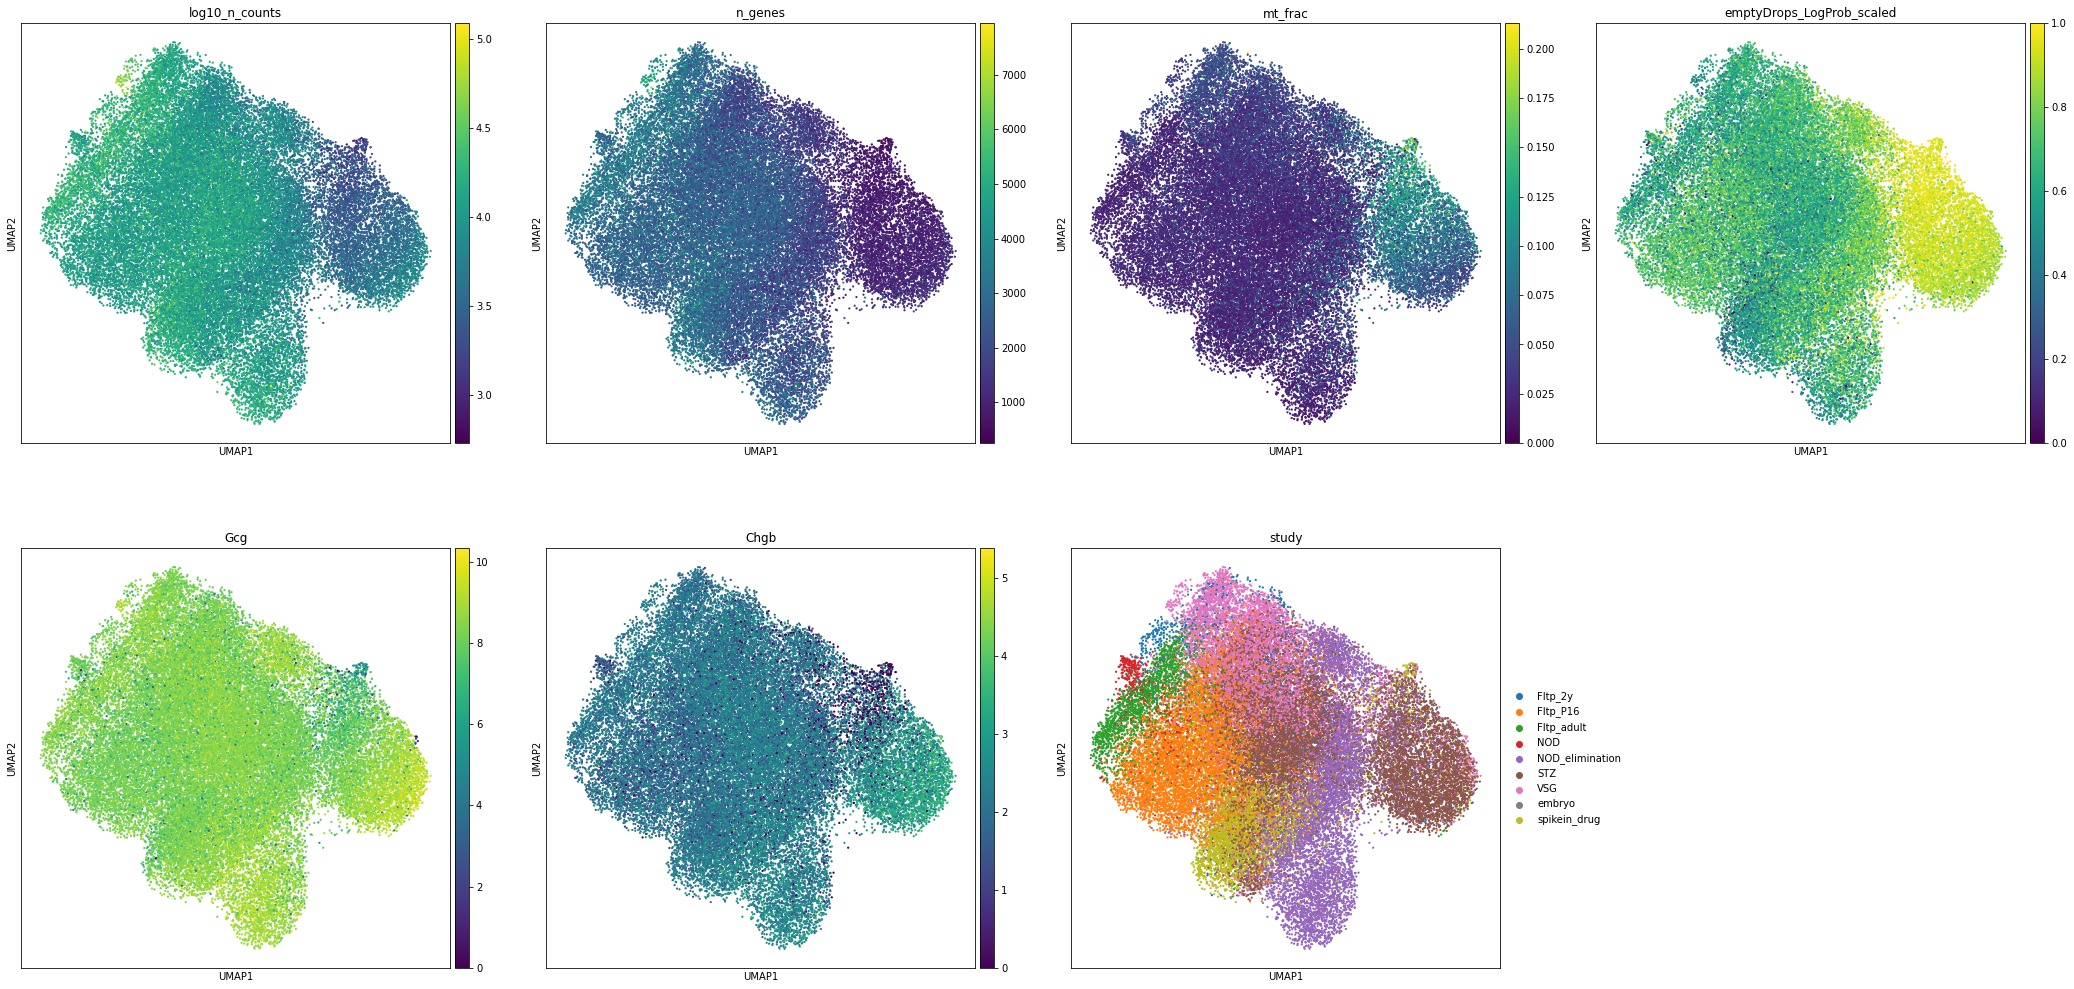

In [36]:
# Plot QC and markers
rcParams['figure.figsize']=(8,8)
random_indices=np.random.permutation(list(range(adata_rn.shape[0])))
sc.pl.umap(adata_rn[random_indices,:],
           color=['log10_n_counts','n_genes','mt_frac','emptyDrops_LogProb_scaled',
                  'Gcg','Chgb','study'],
           s=20,gene_symbols='gene_symbol',sort_order=False)

Cluster for lowQ removal.

In [39]:
for res in [
    0.5,0.7,1,1.5,1.7,1.8,2, 2.5
]:
    print(res)
    sc.tl.leiden(adata_rn, resolution=res, key_added='leiden_r'+str(res), 
                 directed=True, use_weights=True)

0.5


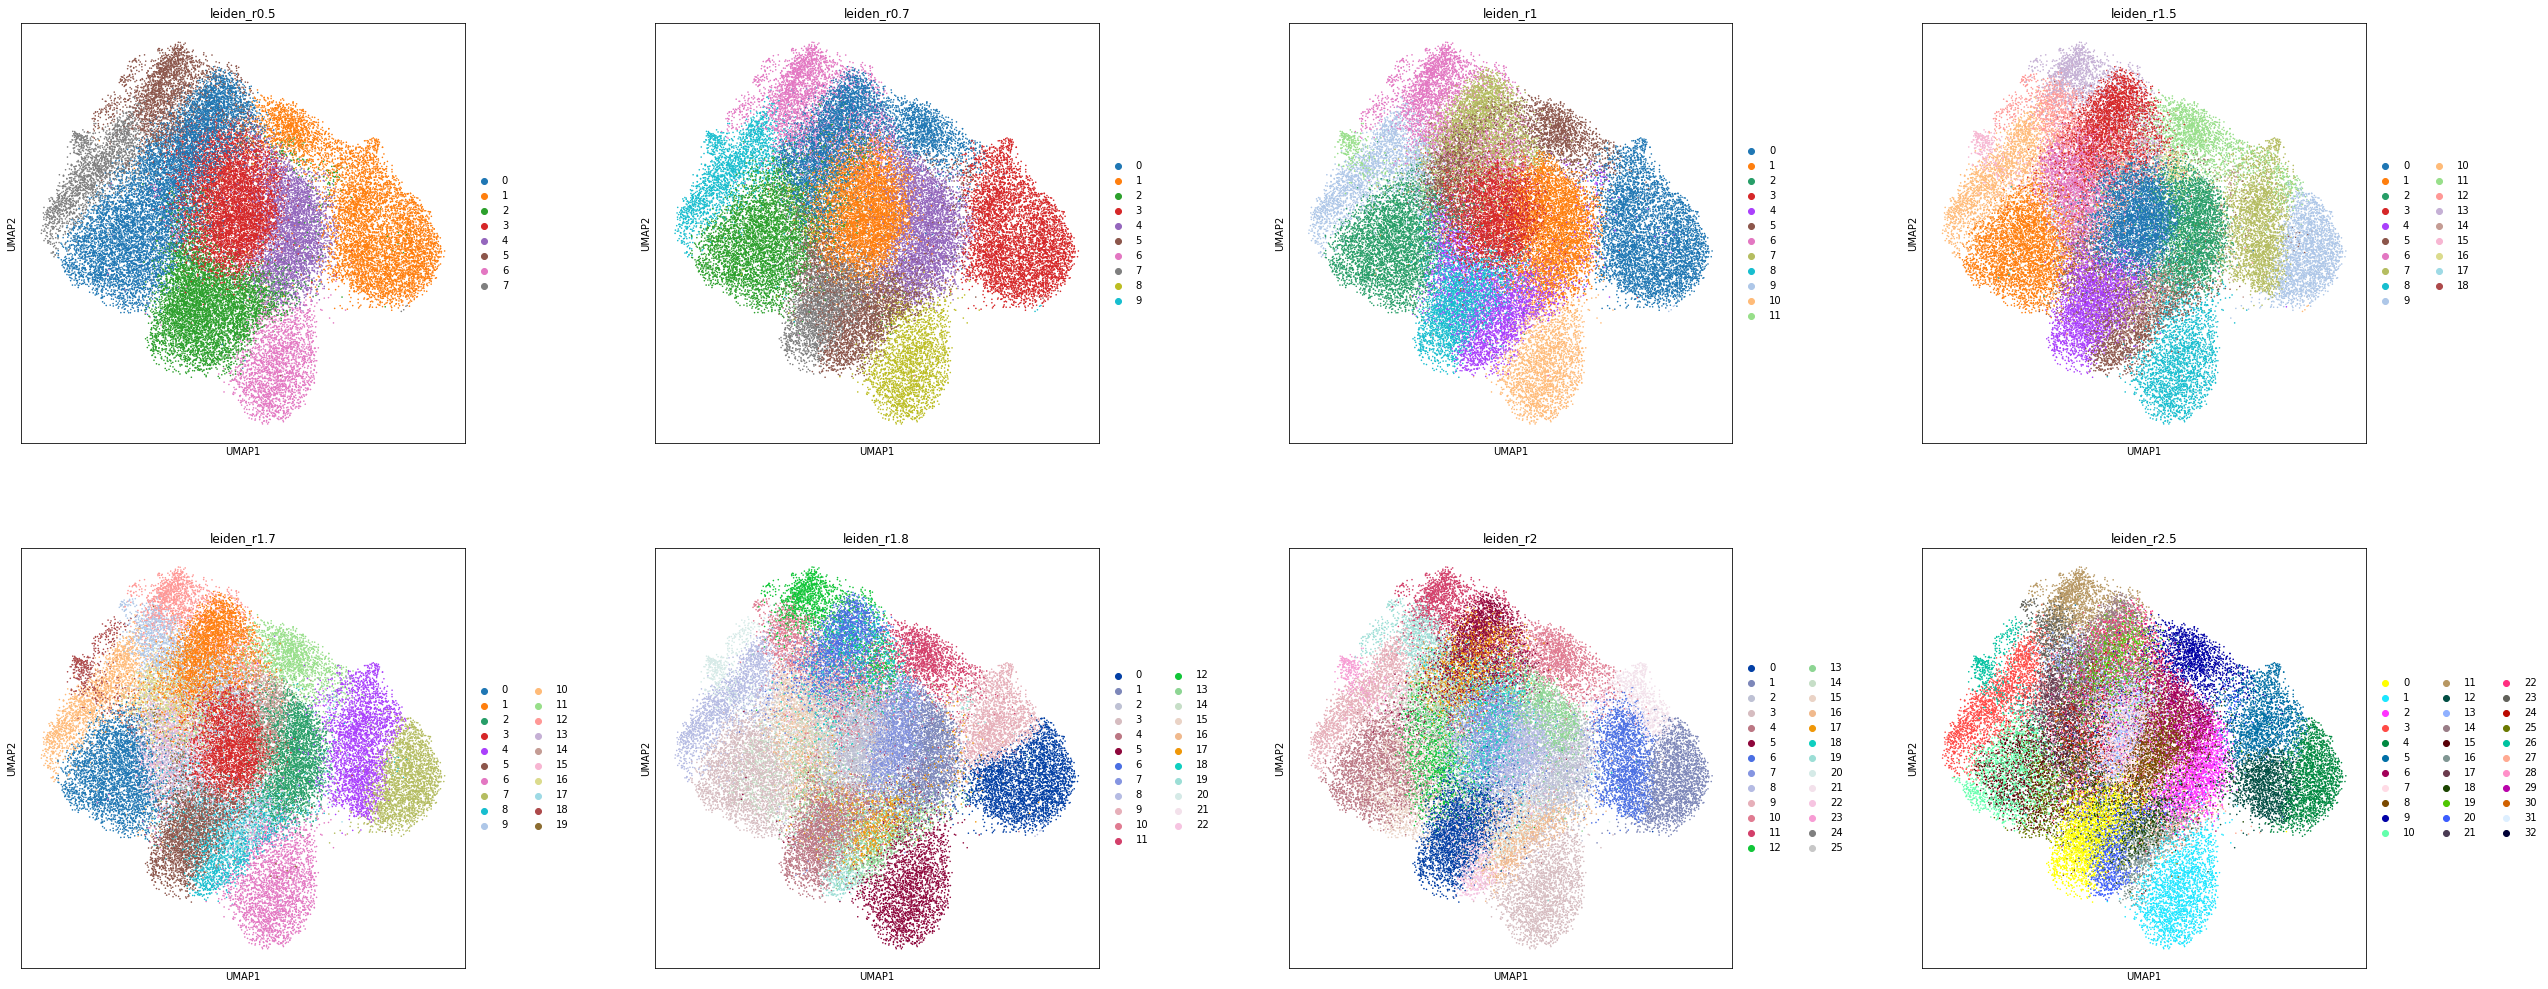

In [40]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata_rn,s=10,color=['leiden_r0.5','leiden_r0.7','leiden_r1','leiden_r1.5',
                                'leiden_r1.7','leiden_r1.8','leiden_r2','leiden_r2.5'],
           wspace=0.3)

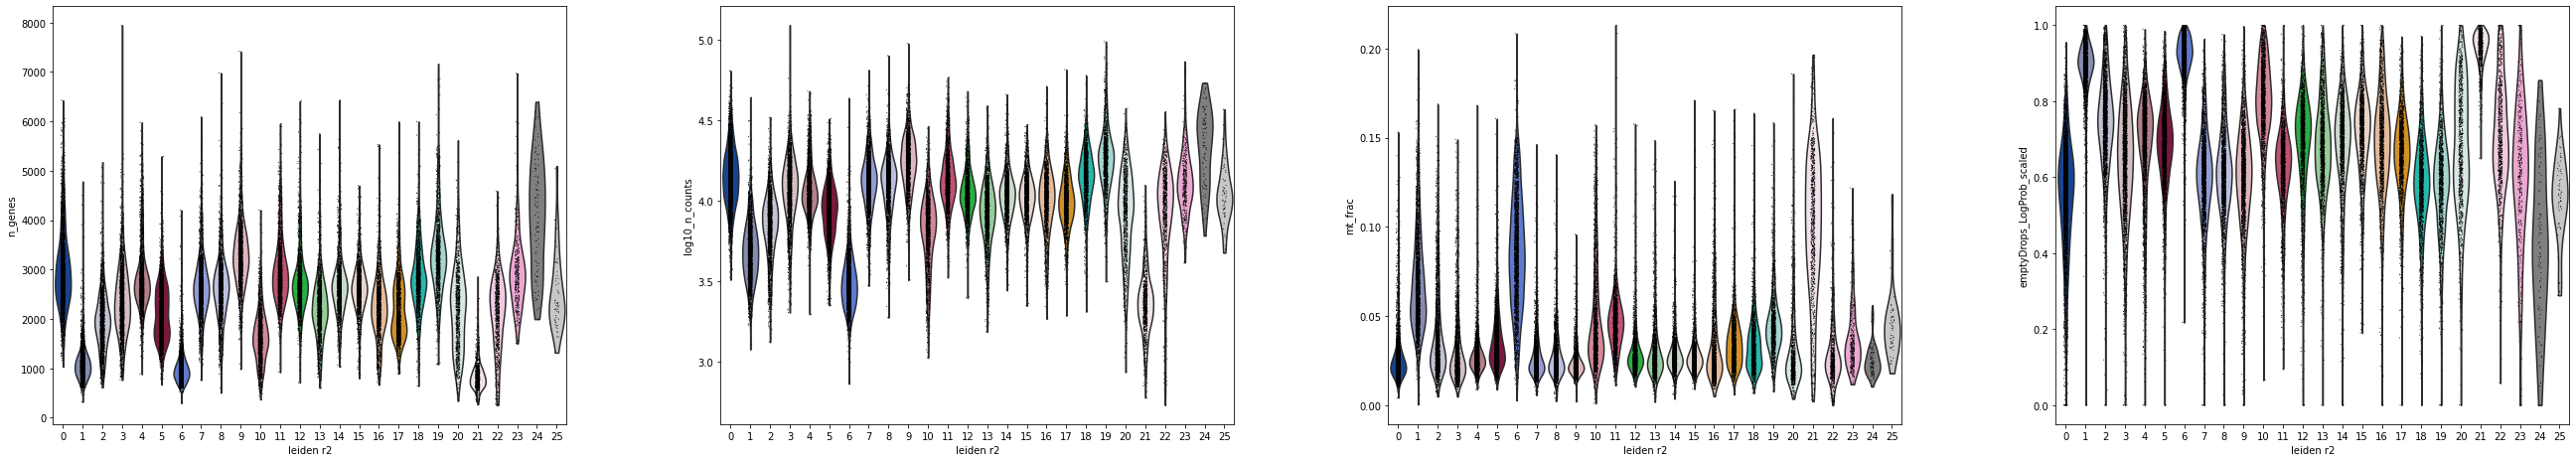

In [38]:
sc.pl.violin(adata_rn,keys=['n_genes','log10_n_counts','mt_frac','emptyDrops_LogProb_scaled'],
             groupby='leiden_r2')

C: Based on whole-atlas UMAP it seems there may be some low quality cells, but it is very hard to disentangle the cluster here, regardless of resolution. thus do subclustering.

#### Subcluster potential low Q part

In [41]:
adata_rn_sub=adata_rn[adata_rn.obs['leiden_r0.5']=='1',:].copy()

In [42]:
# Redo embedding
sc.pp.neighbors(adata_rn_sub, use_rep='X_integrated'  )
sc.tl.umap(adata_rn_sub)

Trying to set attribute `.uns` of view, copying.


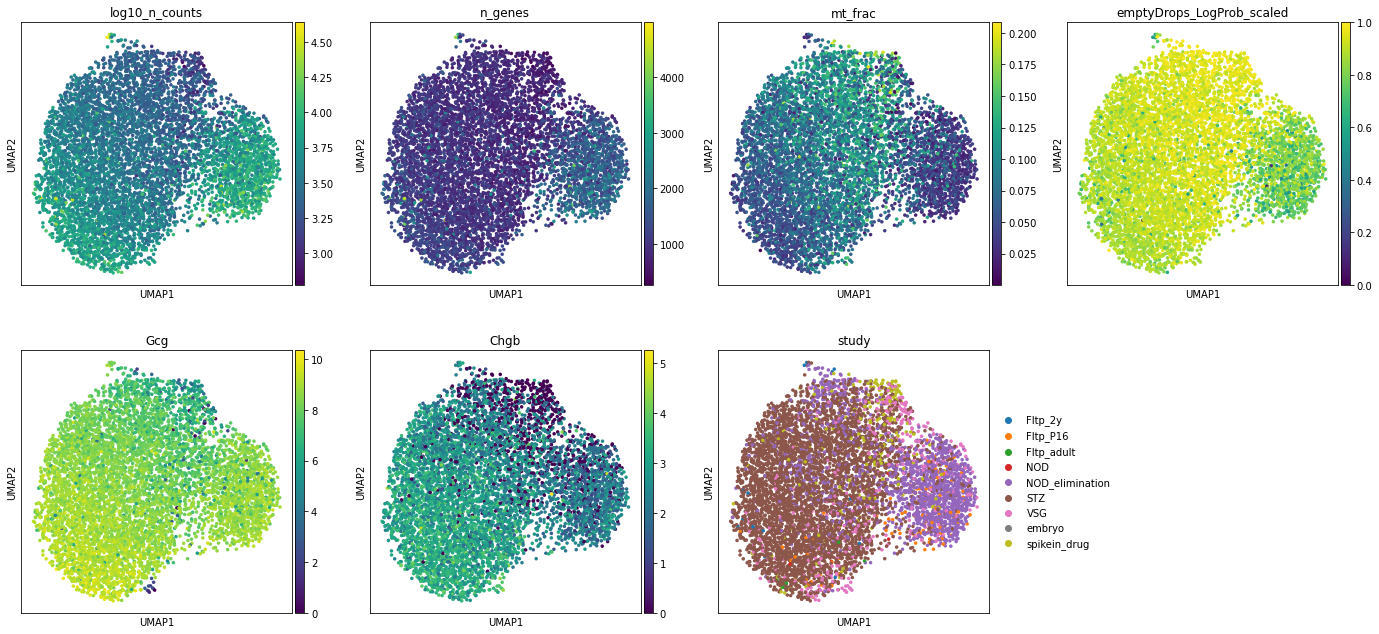

In [44]:
# Plot QC and markers
rcParams['figure.figsize']=(5,5)
random_indices=np.random.permutation(list(range(adata_rn_sub.shape[0])))
sc.pl.umap(adata_rn_sub[random_indices,:],
           color=['log10_n_counts','n_genes','mt_frac','emptyDrops_LogProb_scaled',
                  'Gcg','Chgb','study'],
           s=50,gene_symbols='gene_symbol',sort_order=False)

Cluster for lowQ removal

In [45]:
for res in [
    0.7,1,1.5,
            2,
    2.5
]:
    print(res)
    sc.tl.leiden(adata_rn_sub, resolution=res, key_added='leiden_r'+str(res), 
                 directed=True, use_weights=True)

0.7
1
1.5
2
2.5


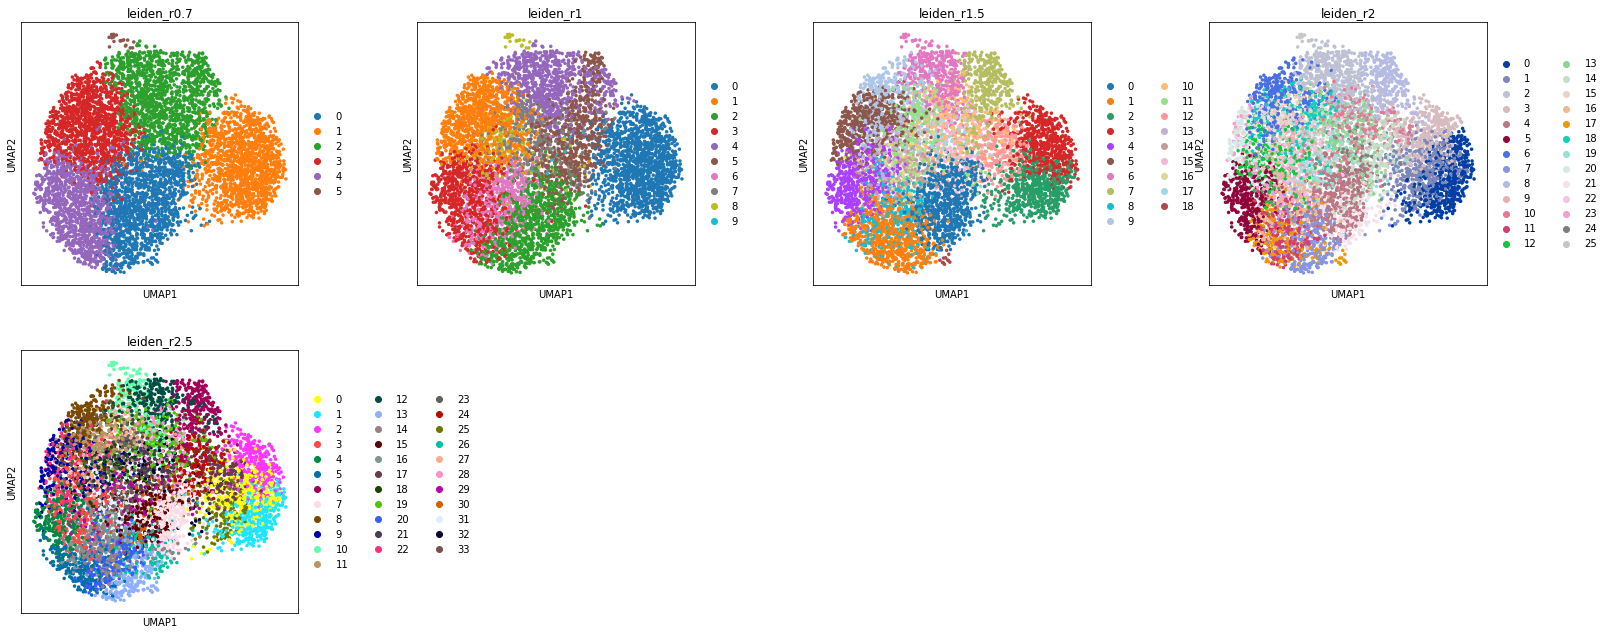

In [48]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_rn_sub,s=50,color=['leiden_r0.7','leiden_r1','leiden_r1.5',
                                'leiden_r2','leiden_r2.5'],
           wspace=0.3)

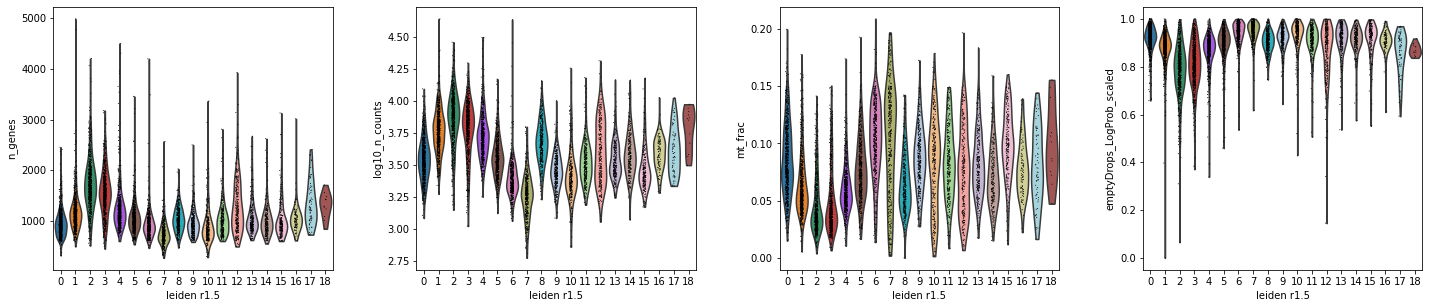

In [59]:
# QC per cluster
sc.pl.violin(adata_rn_sub,keys=['n_genes','log10_n_counts','mt_frac','emptyDrops_LogProb_scaled'],
             groupby='leiden_r1.5')

Plot some markers:
- some alpha markers (Gcg) and some more lowly expressed alpha markers - less likely storng ambient effect
- some genes that seem to be low in low quality - Chga/b
- other ct hormones as Chgb/a also expressed in otehr endo and may give insight into ambience

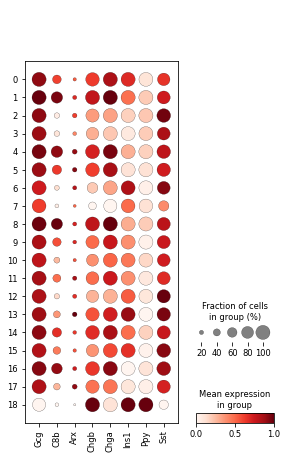

In [57]:
sc.pl.dotplot(adata_rn_sub,groupby='leiden_r1.5',
              var_names=['Gcg','C8b','Arx','Chgb','Chga','Ins1','Ppy','Sst'],
              gene_symbols='gene_symbol',standard_scale='var')

C: Maybe cluster 7 is low quality. Potential subcl 18 may be doublet, but it is so small (see umaps above) that irrelevant.

In [72]:
# Add lowQ anno
adata_rn.obs['low_quality']=np.nan
adata_rn.obs.loc[
    adata_rn_sub.obs_names[adata_rn_sub.obs['leiden_r1.5'].isin(['7'])],'low_quality']=True
adata_rn.obs['low_quality'].fillna(False,inplace=True)

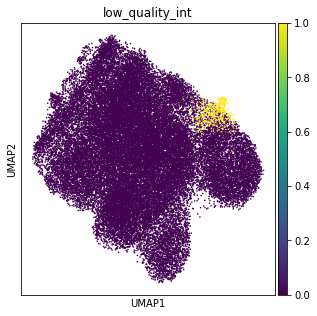

In [73]:
# Plot low Q anno
rcParams['figure.figsize']=(5,5)
adata_rn.obs['low_quality_int']=adata_rn.obs['low_quality'].astype(int)
sc.pl.umap(adata_rn,color='low_quality_int',s=10)
adata_rn.obs.drop('low_quality_int',axis=1,inplace=True)

### Save adata

In [65]:
# Save
adata_rn.write(path_data+'data_rawnorm_integrated_analysed_alpha.h5ad')

In [66]:
adata_rn

AnnData object with n_obs × n_vars = 40935 × 30672
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'design', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'size_factors_integrated', 'emptyDrops_LogProb', 'n_counts', 'log10_n_counts', 'n_genes', 'mt_frac', 'leiden_r0.7', 'leiden_r1', 'leiden_r1.5', 'leiden_r2', 'emptyDrops_LogProb_scaled', 'leiden_r1.7', 'leiden_r1.8', 'leiden_r2.5', 'leiden_r0.5', 'low_quality'
    var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched'
    uns: 'cell_type_multiplet_colors', 'neighbors', 'pre_cell_type_colors', 'umap', 'leiden', 'leiden_r0.7_colors', 'leiden_r1_